# Image Based Pointcloud Segmentation

Kefeng Huang
timkhuang@icloud.com

## Packages

In [1]:
import os
import numpy as np
from collections import deque
from statistics import mode
import matplotlib.pyplot as plt
%matplotlib inline

# Kitti Dataset Helper
import pykitti
from kitti_labels import kitti_colors, cityscapes2kitti

# Utility Functions
from project import points2image_project, frame2frame_project

## Datasets

This project is using *Kitti Odometry* for point cloud and calibration data and *SemanticKitti* for corresponding labels. 


* *Kitti Odometry*: http://www.cvlibs.net/datasets/kitti/eval_odometry.php
* *SemanticKITTI* : http://www.semantic-kitti.org/

In [10]:
kitti_dataset_path = r'/home/t1mkhuan9/Datasets/kitti/dataset'
# specify which sequence(s) to use
seq = '00'

kitti_dataset = pykitti.odometry(kitti_dataset_path, sequence=seq)

## Image Segmentation

Load the labels for image from file.
Labels are created by applying *NVIDIA/Semantic-Segmentation* using pertrained_model *kitti_best.pth* and network *deepv3.DeepWV3Plus*.

Since it is using cityscapes labels, additional step is required to
translate to kitti labels to match *semanticKITTI* result.

In [11]:
image_label_path = r"./image_labels"

In [12]:
cols, rows = kitti_dataset.get_cam2(0).size
    
path = os.path.join(image_label_path, "sequences", seq)

labels = [
    np.fromfile(os.path.join(path, label), dtype=np.int64)
    for label in sorted(os.listdir(path))
]

image_sequence_label = [
    np.array([cityscapes2kitti[label] for label in img]).reshape((rows, cols))
    for img in labels
]

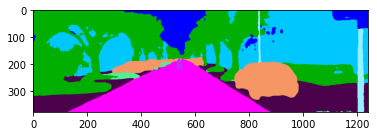

In [13]:
sample_labelled_img = np.array([
    [kitti_colors[i] for i in row] 
    for row in image_sequence_label[0]
])

plt.imshow(sample_labelled_img)

## Project Points to Images

In [14]:
prev_count = 5
output_path = r'./predicted_labels/sequences/' + seq

In [15]:
previous_img_labels = deque(maxlen=prev_count)
previous_poses = deque(maxlen=prev_count)

for idx, velo in enumerate(kitti_dataset.velo):
    pose = kitti_dataset.poses[idx]
    labels = image_sequence_label[idx]

    pred = {
        tuple(v[:3]) : [] for v in velo
    }

    # current scan
    velo_xyz, img_xy = points2image_project(velo, kitti_dataset.calib)

    for i in range(velo_xyz.shape[1]):

        try:
            label = labels[np.int32(img_xy[1][i]), np.int32(img_xy[0][i])]
        except IndexError:
            continue

        xyz = (velo_xyz[0][i], velo_xyz[1][i], velo_xyz[2][i])
        pred[xyz].append(label)

    # previous scans
    for prelabel, prepose in zip(previous_img_labels, previous_poses):

        # project current points to previous coordinate system
        pre_velo = frame2frame_project(velo, pose, prepose, kitti_dataset.calib.T_cam0_velo)
        paired_points = { tuple(pre[:3]) : tuple(cur[:3]) for pre, cur in zip(pre_velo, velo) }

        # match previous points with previous image
        pre_velo_xyz, pre_img_xy = points2image_project(pre_velo, kitti_dataset.calib)

        for i in range(pre_velo_xyz.shape[1]):
            try:
                label = prelabel[np.int32(pre_img_xy[1][i]), np.int32(pre_img_xy[0][i])]
            except IndexError:
                continue

            pre_xyz = (pre_velo_xyz[0][i], pre_velo_xyz[1][i], pre_velo_xyz[2][i])
            xyz = paired_points[pre_xyz]
            
            pred[xyz].append(label)
    
    # process to get final prediction
    final_pred = []

    for point in velo:
        xyz = (point[0], point[1], point[2])
        value = pred[xyz]

        if len(value) == 0:
            final_pred.append(0)
            continue
        final_pred.append(mode(value))

    final_pred = np.array(final_pred, dtype=np.int32)
    final_pred.tofile(os.path.join(output_path, f'{idx:06d}.label'))
    
    previous_img_labels.append(labels)
    previous_poses.append(pose)

    print(idx, "Finished")


0 Finished
1 Finished
2 Finished
3 Finished
4 Finished
5 Finished
6 Finished
7 Finished
8 Finished
9 Finished
10 Finished
11 Finished
12 Finished
13 Finished
14 Finished
15 Finished
16 Finished
17 Finished
18 Finished
19 Finished
20 Finished
21 Finished
22 Finished
23 Finished
24 Finished
25 Finished
26 Finished
27 Finished
28 Finished
29 Finished
30 Finished
31 Finished
32 Finished
33 Finished
34 Finished
35 Finished
36 Finished
37 Finished
38 Finished
39 Finished
40 Finished
41 Finished
42 Finished
43 Finished
44 Finished
45 Finished
46 Finished
47 Finished
48 Finished
49 Finished
50 Finished
51 Finished
52 Finished
53 Finished
54 Finished
55 Finished
56 Finished
57 Finished
58 Finished
59 Finished
60 Finished
61 Finished
62 Finished
63 Finished
64 Finished
65 Finished
66 Finished
67 Finished
68 Finished
69 Finished
70 Finished
71 Finished
72 Finished
73 Finished
74 Finished
75 Finished
76 Finished
77 Finished
78 Finished
79 Finished
80 Finished
81 Finished
82 Finished
83 Finished
84

## Result

The results are viusalised and evaluated using *semantic-kitti-api*

![image](./sample_result.png)

**Result on sequence 00 and 01**

Acc avg 0.799

IoU avg 0.158


| Index | Class | IoU |
| :---        |    :----:   |          ---: |
| 1  | car | 0.359 |
| 2|bicycle|0.060
| 3|motorcycle|0.236
| 4|truck|0.140
| 5|other-vehicle|0.000
| 6|person|0.193
| 7|bicyclist|0.054
| 8|motorcyclist|0.000
| 9|road|0.534
| 10|parking|0.000
| 11|sidewalk|0.251
| 12|other-ground|0.000
| 13|building|0.175
| 14|fence|0.187
| 15|vegetation|0.250
| 16|trunk|0.000
| 17|terrain|0.274
| 18|pole|0.154
| 19|traffic-sign|0.138




In [ ]:
Diff prev_count

6 smallest